# CODECLAUSE DATA SCIENCE INTERSHIP PROGRAM



---


**AUTHOR - Nikhil Eshwar T**



**TASK 2 - Brain Tumor Detection**


# Importing Necessary Libraries

In [ ]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix , classification_report
import os
import shutil
import json
import itertools
import pathlib
from PIL import Image
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D , MaxPooling2D , Flatten , Activation , Dense , Dropout , BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam , Adamax
from tensorflow.keras import regularizers
import warnings
warnings.filterwarnings('ignore')

Accessing the Kaggle API

In [ ]:
#Open and read the JSON file
with open('kaggle (1).json', 'r') as json_file:
    data = json.load(json_file)

#Access specific values from the loaded JSON data
username = data['username']
key= data['key']

In [ ]:
os.environ['KAGGLE_USERNAME'] =username
os.environ['KAGGLE_KEY'] =key

Downloading the dataset

In [ ]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

 98% 145M/149M [00:01<00:00, 166MB/s]
100% 149M/149M [00:01<00:00, 129MB/s]


In [ ]:
!unzip brain-tumor-mri-dataset

Streaming output truncated to the last 5000 lines.
  inflating: Training/glioma/Tr-gl_0712.jpg  
  inflating: Training/glioma/Tr-gl_0713.jpg  
  inflating: Training/glioma/Tr-gl_0714.jpg  
  inflating: Training/glioma/Tr-gl_0715.jpg  
  inflating: Training/glioma/Tr-gl_0716.jpg  
  inflating: Training/glioma/Tr-gl_0717.jpg  
  inflating: Training/glioma/Tr-gl_0718.jpg  
  inflating: Training/glioma/Tr-gl_0719.jpg  
  inflating: Training/glioma/Tr-gl_0720.jpg  
  inflating: Training/glioma/Tr-gl_0721.jpg  
  inflating: Training/glioma/Tr-gl_0722.jpg  
  inflating: Training/glioma/Tr-gl_0723.jpg  
  inflating: Training/glioma/Tr-gl_0724.jpg  
  inflating: Training/glioma/Tr-gl_0725.jpg  
  inflating: Training/glioma/Tr-gl_0726.jpg  
  inflating: Training/glioma/Tr-gl_0727.jpg  
  inflating: Training/glioma/Tr-gl_0728.jpg  
  inflating: Training/glioma/Tr-gl_0729.jpg  
  inflating: Training/glioma/Tr-gl_0730.jpg  
  inflating: Training/glioma/Tr-gl_0731.jpg  
  inflating: Training/glioma/

## Training Data

In [ ]:
train_data_path = 'Training'

filepaths =[]
labels = []

folds = os.listdir(train_data_path)

for fold in folds:
    f_path = os.path.join(train_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
train_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
train_df

,filepaths,label
0,Training/meningioma/Tr-me_1116.jpg,meningioma
1,Training/meningioma/Tr-me_1266.jpg,meningioma
2,Training/meningioma/Tr-me_0095.jpg,meningioma
3,Training/meningioma/Tr-me_0867.jpg,meningioma
4,Training/meningioma/Tr-me_1275.jpg,meningioma
...,...,...
5707,Training/glioma/Tr-gl_0979.jpg,glioma
5708,Training/glioma/Tr-gl_1114.jpg,glioma
5709,Training/glioma/Tr-gl_0667.jpg,glioma
5710,Training/glioma/Tr-gl_0241.jpg,glioma


## Testing Data

In [ ]:
test_data_path ='Testing'

filepaths =[]
labels = []

folds = os.listdir(test_data_path)

for fold in folds:
    f_path = os.path.join(test_data_path , fold)
    filelists = os.listdir(f_path)

    for file in filelists:
        filepaths.append(os.path.join(f_path , file))
        labels.append(fold)

#Concat data paths with labels
Fseries = pd.Series(filepaths , name = 'filepaths')
Lseries = pd.Series(labels , name = 'label')
test_df = pd.concat([Fseries , Lseries] , axis = 1)

In [ ]:
test_df

,filepaths,label
0,Testing/meningioma/Te-me_0030.jpg,meningioma
1,Testing/meningioma/Te-me_0253.jpg,meningioma
2,Testing/meningioma/Te-me_0128.jpg,meningioma
3,Testing/meningioma/Te-me_0190.jpg,meningioma
4,Testing/meningioma/Te-me_0278.jpg,meningioma
...,...,...
1306,Testing/glioma/Te-gl_0031.jpg,glioma
1307,Testing/glioma/Te-gl_0027.jpg,glioma
1308,Testing/glioma/Te-gl_0252.jpg,glioma
1309,Testing/glioma/Te-gl_0018.jpg,glioma


## Splitting the data

In [ ]:
valid , test = train_test_split(test_df , train_size = 0.5 , shuffle = True , random_state= 42)

## Image Data Generator

In [ ]:
img_size = (224 ,244)
batch_size = 16

tr_gen = ImageDataGenerator()
ts_gen= ImageDataGenerator()

train_gen = tr_gen.flow_from_dataframe(train_df , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode = 'rgb' , shuffle = True , batch_size =batch_size)

valid_gen = ts_gen.flow_from_dataframe(valid , x_col = 'filepaths' , y_col = 'label' , target_size = img_size ,
                                       class_mode = 'categorical',color_mode = 'rgb' , shuffle= True, batch_size = batch_size)

test_gen = ts_gen.flow_from_dataframe(test , x_col= 'filepaths' , y_col = 'label' , target_size = img_size ,
                                      class_mode = 'categorical' , color_mode= 'rgb' , shuffle = False , batch_size = batch_size)

Found 5712 validated image filenames belonging to 4 classes.
Found 655 validated image filenames belonging to 4 classes.
Found 656 validated image filenames belonging to 4 classes.


## Displaying sample images

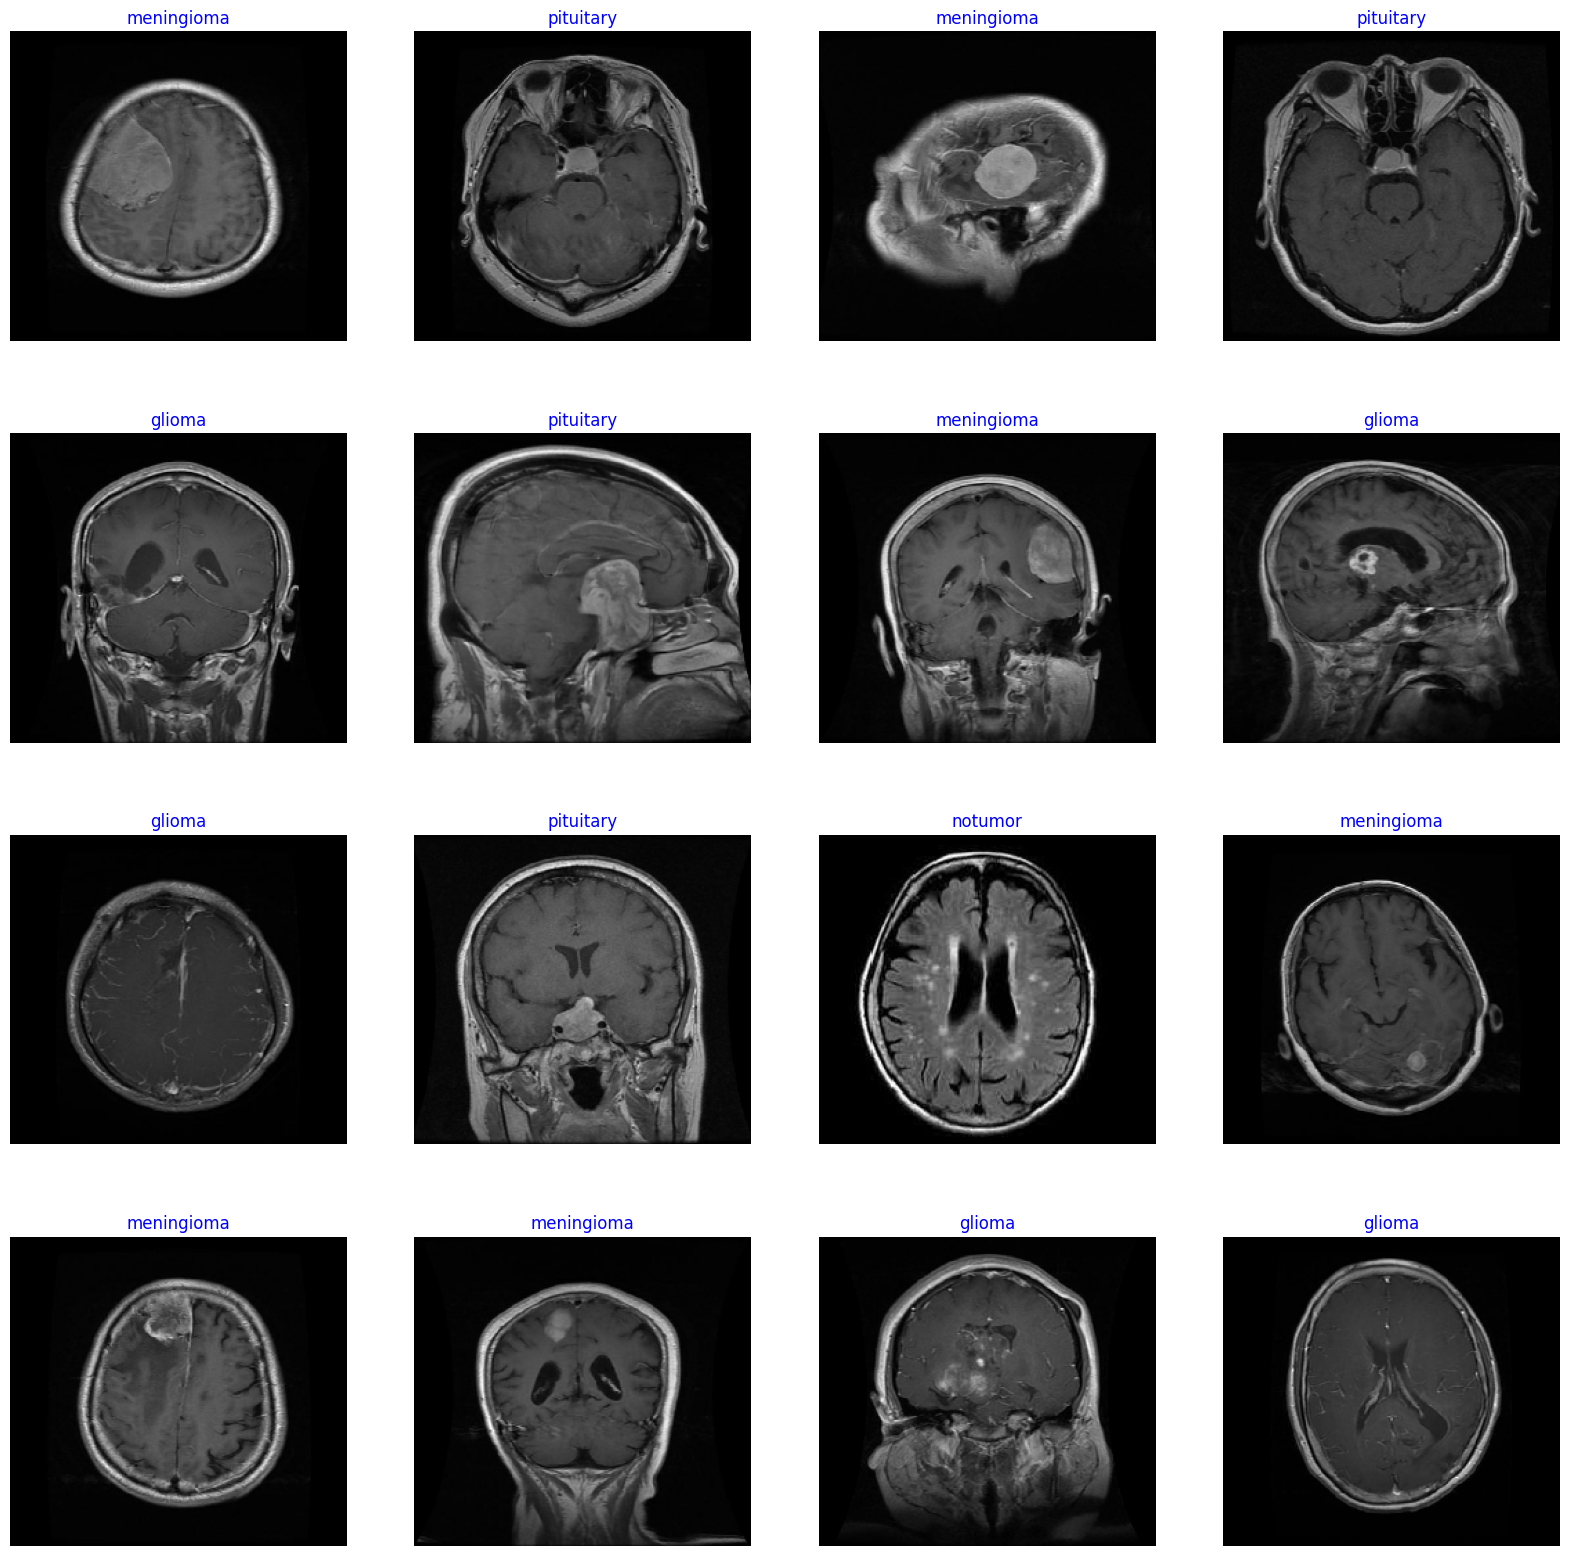

In [ ]:
gen_dict = train_gen.class_indices
classes = list(gen_dict.keys())
images , labels = next(train_gen)

plt.figure(figsize= (20,20))

for i in range(16):
    plt.subplot(4,4,i+1)
    image = images[i] / 255
    plt.imshow(image)
    index = np.argmax(labels[i])
    class_name = classes[index]
    plt.title(class_name , color = 'blue' , fontsize= 12)
    plt.axis('off')
plt.show();

# Model Creation

In [ ]:
img_shape = (img_size[0] , img_size[1] , 3)
num_class = len(classes)

base_model = tf.keras.applications.efficientnet.EfficientNetB3(include_top = False , weights = 'imagenet' ,
                                                               input_shape = img_shape, pooling= 'max')
model = Sequential([
    base_model,
    BatchNormalization(axis= -1 , momentum= 0.99 , epsilon= 0.001),
    Dense(256, kernel_regularizer = regularizers.l2(l= 0.016) , activity_regularizer = regularizers.l1(0.006),
         bias_regularizer= regularizers.l1(0.006) , activation = 'relu'),
    Dropout(rate= 0.4 , seed = 75),
    Dense(num_class , activation = 'softmax')
])

model.compile(Adamax(learning_rate = 0.001) , loss = 'categorical_crossentropy', metrics = ['accuracy'])
model.summary()

43941136/43941136 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 batch_normalization (Batch  (None, 1536)              6144      
 Normalization)                                                  
                                                                 
 dense (Dense)               (None, 256)               393472    
                                                                 
 dropout (Dropout)           (None, 256)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 1028      
                                                         

# Model Training

In [ ]:
Epochs = 15

history = model.fit(x= train_gen , epochs = Epochs , verbose = 1 , validation_data = valid_gen ,
                   validation_steps = None , shuffle = False)

Epoch 1/15
357/357 [==============================] - 112s 313ms/step - loss: 5.1068 - accuracy: 0.9109 - val_loss: 3.4221 - val_accuracy: 0.9664
Epoch 2/15
357/357 [==============================] - 113s 316ms/step - loss: 2.4484 - accuracy: 0.9657 - val_loss: 1.6618 - val_accuracy: 0.9847
Epoch 3/15
357/357 [==============================] - 106s 297ms/step - loss: 1.2259 - accuracy: 0.9804 - val_loss: 0.8208 - val_accuracy: 0.9878
Epoch 4/15
357/357 [==============================] - 104s 291ms/step - loss: 0.6438 - accuracy: 0.9874 - val_loss: 0.4442 - val_accuracy: 0.9908
Epoch 5/15
357/357 [==============================] - 105s 293ms/step - loss: 0.3791 - accuracy: 0.9872 - val_loss: 0.3126 - val_accuracy: 0.9786
Epoch 6/15
357/357 [==============================] - 104s 292ms/step - loss: 0.2537 - accuracy: 0.9916 - val_loss: 0.1993 - val_accuracy: 0.9954
Epoch 7/15
357/357 [==============================] - 106s 296ms/step - loss: 0.2057 - accuracy: 0.9918 - val_loss: 0.1770 -

# Model Performance

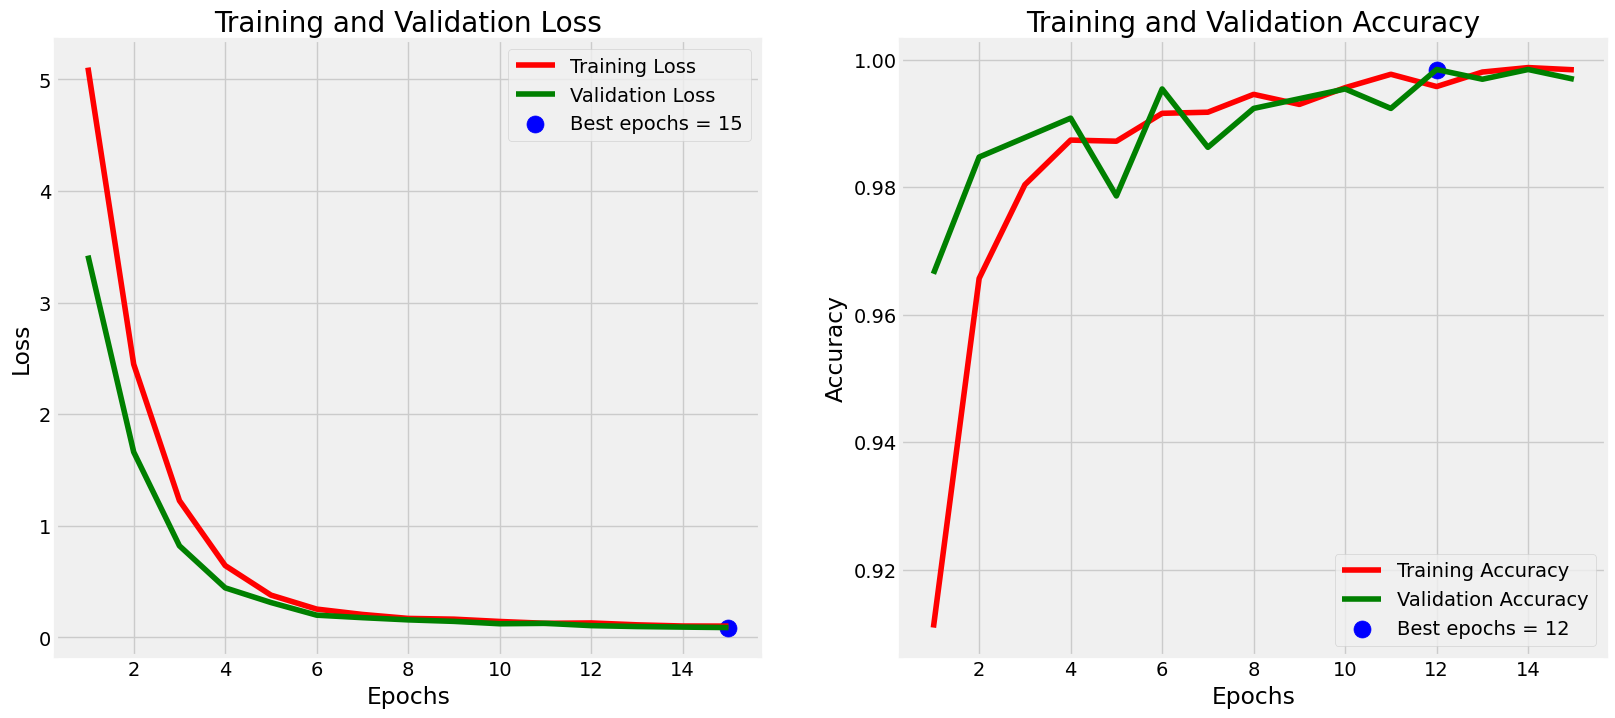

In [ ]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']

val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']

index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]

index_acc = np.argmax(val_acc)
val_highest = val_acc[index_acc]

Epochs = [i+1 for i in range(len(train_acc))]

loss_label = f'Best epochs = {str(index_loss +1)}'
acc_label = f'Best epochs = {str(index_acc + 1)}'

#Training history

plt.figure(figsize= (20,8))
plt.style.use('fivethirtyeight')

plt.subplot(1,2,1)
plt.plot(Epochs , train_loss , 'r' , label = 'Training Loss')
plt.plot(Epochs , val_loss , 'g' , label = 'Validation Loss')
plt.scatter(index_loss + 1 , val_lowest , s = 150 , c = 'blue',label = loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(Epochs , train_acc , 'r' , label = 'Training Accuracy')
plt.plot(Epochs , val_acc , 'g' , label = 'Validation Accuracy')
plt.scatter(index_acc + 1 , val_highest , s = 150 , c = 'blue',label = acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout
plt.show();

# Model Evaluation

In [ ]:
train_score = model.evaluate(train_gen , steps =16 , verbose = 1)
valid_score = model.evaluate(valid_gen , steps = 16 , verbose = 1)
test_score = model.evaluate(test_gen , steps = 16 , verbose = 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

16/16 [==============================] - 1s 70ms/step - loss: 0.0938 - accuracy: 0.9922
Train Loss:  0.08169728517532349
Train Accuracy:  1.0
--------------------
Validation Loss:  0.08066746592521667
Validation Accuracy:  0.99609375
--------------------
Test Loss:  0.0938170850276947
Test Accuracy:  0.9921875


# Model Prediction

In [ ]:
preds = model.predict_generator(test_gen)

y_pred = np.argmax(preds , axis = 1)

## Confusion Matrix

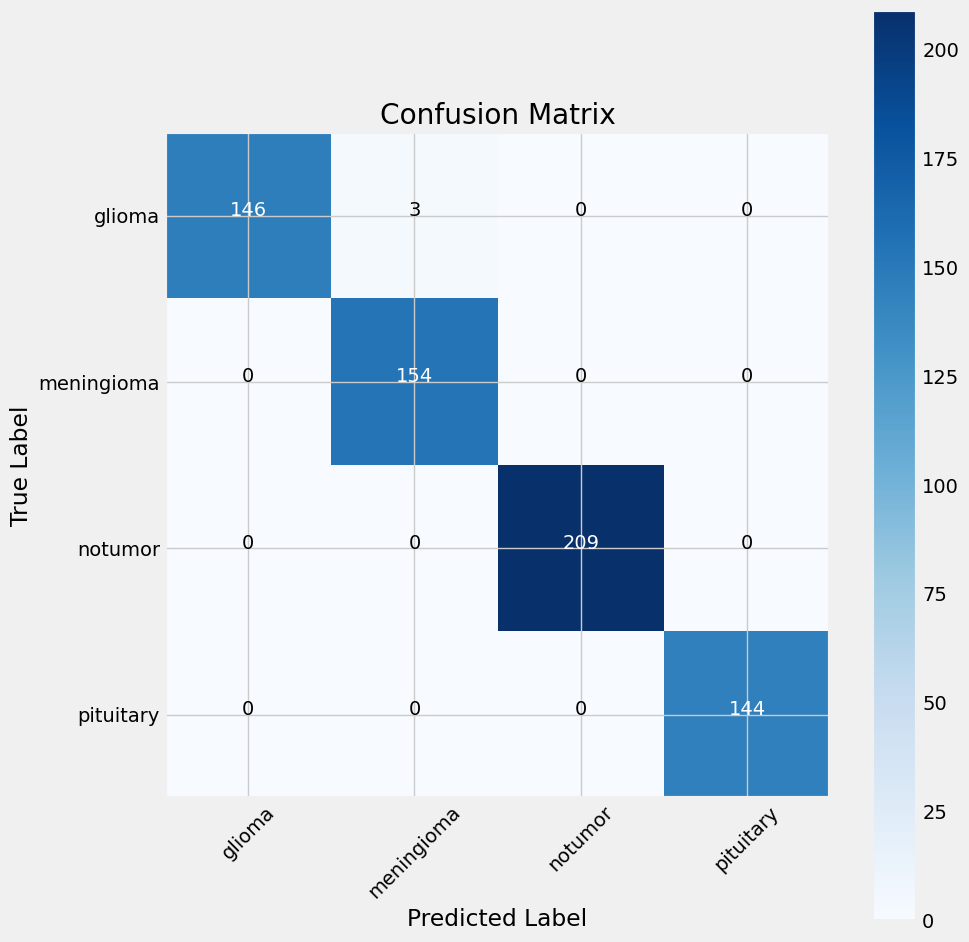

In [ ]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_gen.classes, y_pred)

plt.figure(figsize= (10, 10))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

## Classification report

In [ ]:
print(classification_report(test_gen.classes, y_pred , target_names= classes ))

              precision    recall  f1-score   support

      glioma       1.00      0.98      0.99       149
  meningioma       0.98      1.00      0.99       154
     notumor       1.00      1.00      1.00       209
   pituitary       1.00      1.00      1.00       144

    accuracy                           1.00       656
   macro avg       1.00      0.99      1.00       656
weighted avg       1.00      1.00      1.00       656

